<a href="https://colab.research.google.com/github/mohamed-saeed10/Image-Caption-Generator/blob/main/Image_Caption_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
adityajn105_flickr8k_path = kagglehub.dataset_download('adityajn105/flickr8k')

print('Data source import complete.')


Data source import complete.


# Image Captioning with PyTorch

Install necessary libraries.

In [ ]:
!pip install torch torchvision torchtext kaggle pandas numpy pillow matplotlib tqdm
!pip install arabic_reshaper python-bidi
import arabic_reshaper
from bidi.algorithm import get_display

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 89.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

Import libraries.

In [ ]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import kagglehub
import re
from collections import Counter
import copy
import textwrap
import random

## Download and Prepare Dataset

Download the Flickr8k dataset using Kaggle Hub.

In [ ]:
# Download latest version
dataset_path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", dataset_path)

Path to dataset files: /kaggle/input/flickr8k


## Preprocessing Captions

Load captions, limit the dataset size for faster experimentation, and clean the text.

In [ ]:
# Construct paths using the downloaded dataset path
image_dir = os.path.join(dataset_path, 'Images')
captions_file = os.path.join(dataset_path, 'captions.txt')

captions_df = pd.read_csv(captions_file)
print(f"Original captions shape: {captions_df.shape}")

# # Limit dataset to first 256 images and their captions for quicker testing
# unique_imgs = captions_df['image'].unique()[:256]
# captions_df = captions_df[captions_df['image'].isin(unique_imgs)].reset_index(drop=True)

print(f"Limited captions shape: {captions_df.shape}")
captions_df.head()

Original captions shape: (40455, 2)
Limited captions shape: (40455, 2)


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


Define special tokens and a function to clean caption text.

In [ ]:
# Define special tokens
PAD_TOKEN = '<pad>'
OOV_TOKEN = '<unk>'
START_TOKEN = '<start>'
END_TOKEN = '<end>'

def clean_text(txt):
    txt = txt.lower()
    txt = re.sub(r"[^a-z ]", "", txt) # Keep only lowercase letters and spaces
    txt = re.sub(r"\s+", " ", txt).strip() # Replace multiple spaces with single space
    return f"{START_TOKEN} {txt} {END_TOKEN}"

captions_df['clean'] = captions_df['caption'].apply(clean_text)
all_caps = captions_df['clean'].tolist()
captions_df.head()

,image,caption,clean
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,<start> a child in a pink dress is climbing up...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,<start> a girl going into a wooden building <end>
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,<start> a little girl climbing into a wooden p...
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,<start> a little girl climbing the stairs to h...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,<start> a little girl in a pink dress going in...


Build the vocabulary based on word frequency.

In [ ]:
# build vocabulary
# build counts
word_counts = Counter(w for cap in all_caps for w in cap.split())
# define special tokens
special_tokens = [PAD_TOKEN, OOV_TOKEN, START_TOKEN, END_TOKEN]
# select words above threshold (e.g., count >= 5), excluding special tokens
vocab = [w for w,c in word_counts.items() if c>=5 and w not in special_tokens]
# initialize mapping with special tokens first
word2idx = {tok:i for i,tok in enumerate(special_tokens)}
# add vocab words
for i,w in enumerate(vocab):
    word2idx[w] = i + len(special_tokens)
# create reverse mapping
idx2word = {i:w for w,i in word2idx.items()}
# update vocab_size
vocab_size = len(word2idx)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 2988


Split the data into training and validation sets.

In [ ]:
# split train/val based on unique images
imgs = captions_df['image'].unique().tolist()
split = int(0.85*len(imgs))
train_imgs = set(imgs[:split])
val_imgs   = set(imgs[split:])
train_df = captions_df[captions_df['image'].isin(train_imgs)].reset_index(drop=True)
val_df   = captions_df[captions_df['image'].isin(val_imgs)].reset_index(drop=True)
print(f"Training images: {len(train_imgs)}, Validation images: {len(val_imgs)}")
print(f"Training captions: {len(train_df)}, Validation captions: {len(val_df)}")

Training images: 6877, Validation images: 1214
Training captions: 34385, Validation captions: 6070


## Feature Extraction with Pretrained CNN

Use a pretrained DenseNet201 to extract image features. Define image transformations and the feature extraction process.

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os
import numpy as np
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load pretrained EfficientNet (replacing DenseNet201)
# You can choose different EfficientNet versions: B0-B7 (B0 is smallest, B7 is largest)
efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1).to(device)
efficientnet.eval()  # Set to evaluation mode

# Create feature extractor (removing the classifier head)
feature_extractor = nn.Sequential(
    *list(efficientnet.children())[:-1],  # Remove the classifier
    nn.Flatten()
).to(device)

# Define image transformations - use EfficientNet's recommended preprocessing
transform = transforms.Compose([
    transforms.Resize(224),  # EfficientNet has different optimal sizes per variant
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Define directory for saving features
FEATURE_SAVE_DIR = '/kaggle/working/'
os.makedirs(FEATURE_SAVE_DIR, exist_ok=True)
FEATURE_FILE = os.path.join(FEATURE_SAVE_DIR, 'img_feats.npy')

def extract_features(df, img_dir_path, out_file):
    feats = {}
    print(f"Extracting features from images in: {img_dir_path}")
    for img_name in tqdm(df['image'].unique()):
        img_full_path = os.path.join(img_dir_path, img_name)
        try:
            im = Image.open(img_full_path).convert('RGB')
            x = transform(im).unsqueeze(0).to(device)
            with torch.no_grad():
                # Extract features and convert to numpy array
                f = feature_extractor(x).squeeze(0).cpu().numpy()
            feats[img_name] = f
        except FileNotFoundError:
            print(f"Warning: Image not found at {img_full_path}")
        except Exception as e:
            print(f"Error processing {img_name}: {e}")
    np.save(out_file, feats)
    print(f"Features saved to {out_file}")

# Extract features for all images in the dataset
extract_features(captions_df, image_dir, FEATURE_FILE)
img_features = np.load(FEATURE_FILE, allow_pickle=True).item()

Using device: cuda


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 91.4MB/s]


Extracting features from images in: /kaggle/input/flickr8k/Images


100%|██████████| 8091/8091 [03:11<00:00, 42.35it/s]


Features saved to /kaggle/working/img_feats.npy


## Dataset & DataLoader

Define a custom PyTorch Dataset and a collate function for padding sequences in batches.

In [ ]:
class CaptionDataset(Dataset):
    def __init__(self, df, feats, w2i):
        self.df = df
        self.feats = feats
        self.w2i = w2i
        self.oov_idx = w2i.get(OOV_TOKEN, 1) # Default OOV index if not found (should be 1)

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        img_name = row.image
        # Load feature vector
        feat = self.feats.get(img_name)
        if feat is None:
             # Handle case where feature might be missing (though extract_features should cover this)
             print(f"Warning: Feature missing for image {img_name}. Returning zeros.")
             # Determine feature dimension dynamically if possible, otherwise use a placeholder
             feat_dim = list(self.feats.values())[0].shape[0] if self.feats else 1920 # Example dim for DenseNet201
             feat = np.zeros(feat_dim)

        img_tensor = torch.tensor(feat, dtype=torch.float32)
        # Convert caption words to indices, using OOV index for unknown words
        tokens = [self.w2i.get(w, self.oov_idx) for w in row.clean.split()]
        return img_tensor, torch.tensor(tokens)

def collate_fn(batch):
    imgs, seqs = zip(*batch)
    imgs = torch.stack(imgs)
    # Calculate lengths for input sequences (excluding <end> token)
    lengths = [len(s)-1 for s in seqs]
    # Pad input sequences (excluding <end> token)
    inputs = torch.nn.utils.rnn.pad_sequence([s[:-1] for s in seqs], batch_first=True, padding_value=word2idx[PAD_TOKEN])
    # Pad target sequences (excluding <start> token)
    targets = torch.nn.utils.rnn.pad_sequence([s[1:] for s in seqs], batch_first=True, padding_value=word2idx[PAD_TOKEN])
    return imgs, inputs, targets, lengths

# Create Datasets and DataLoaders
train_ds = CaptionDataset(train_df, img_features, word2idx)
val_ds   = CaptionDataset(val_df, img_features, word2idx)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False, collate_fn=collate_fn, num_workers=2)

## Define RNN Models (LSTM, GRU, RNN, BiLSTM)

Define the base LSTM model architecture and variants using GRU, basic RNN, and Bidirectional LSTM layers.

In [ ]:
class LSTMCaption(nn.Module):
    def __init__(self, feat_dim, embed_dim, hidden_dim, vocab_size, dropout_prob=0.5):
        super().__init__()
        self.feat_dim = feat_dim
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.dropout_prob = dropout_prob

        # Layer to project image features to embedding dimension
        self.fc = nn.Linear(feat_dim, embed_dim)
        # Embedding layer for captions
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=word2idx[PAD_TOKEN])
        # LSTM layer
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        # Dropout layer
        self.dropout = nn.Dropout(dropout_prob)
        # Final linear layer to map hidden state to vocabulary
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, feats, seqs, lengths):
        # Project image features and add time dimension: (batch, feat_dim) -> (batch, embed_dim) -> (batch, 1, embed_dim)
        f = self.fc(feats).unsqueeze(1)
        # Embed captions: (batch, seq_len) -> (batch, seq_len, embed_dim)
        e = self.embed(seqs)
        # Concatenate image feature and caption embeddings: (batch, 1 + seq_len, embed_dim)
        x = torch.cat([f, e], dim=1)
        # Pack padded sequence (lengths need to account for the added image feature)
        # Ensure lengths are on CPU for pack_padded_sequence
        cpu_lengths = [l + 1 for l in lengths] # Add 1 for the image feature
        packed = nn.utils.rnn.pack_padded_sequence(x, cpu_lengths, batch_first=True, enforce_sorted=False)
        # Pass through LSTM
        out_packed, _ = self.lstm(packed)
        # Unpack sequence
        out, _ = nn.utils.rnn.pad_packed_sequence(out_packed, batch_first=True)
        # Apply dropout and linear layer
        # We only want the outputs corresponding to the caption tokens, not the image feature input
        # Output shape: (batch, 1 + seq_len, hidden_dim)
        # We slice out the first time step corresponding to the image feature input
        out = out[:, 1:, :] # Shape: (batch, seq_len, hidden_dim)
        return self.linear(self.dropout(out))

## Initialize Models, Optimizers, and Loss Function

In [ ]:
# Determine actual feature dimension from loaded features
feat_dim = list(img_features.values())[0].shape[0]
print(f"Detected feature dimension: {feat_dim}")
embed_dim = 256
hidden_dim = 512 # Increased hidden dimension

# Instantiate models
lstm_model = LSTMCaption(feat_dim=feat_dim, embed_dim=embed_dim, hidden_dim=hidden_dim, vocab_size=vocab_size).to(device)
gru_model = GRUCaption(feat_dim=feat_dim, embed_dim=embed_dim, hidden_dim=hidden_dim, vocab_size=vocab_size).to(device)
rnn_model = RNNCaption(feat_dim=feat_dim, embed_dim=embed_dim, hidden_dim=hidden_dim, vocab_size=vocab_size).to(device)
bi_model  = BiLSTMCaption(feat_dim=feat_dim, embed_dim=embed_dim, hidden_dim=hidden_dim, vocab_size=vocab_size).to(device)

# Define Loss function (ignore padding index)
criterion = nn.CrossEntropyLoss(ignore_index=word2idx[PAD_TOKEN])

# Define Optimizers
lr = 1e-4 # Adjusted learning rate
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=lr)
gru_optimizer = optim.Adam(gru_model.parameters(), lr=lr)
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=lr)
bi_optimizer = optim.Adam(bi_model.parameters(), lr=lr)

# Define directory for saving models
MODEL_SAVE_DIR = '/kaggle/working/saved_models'
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

Detected feature dimension: 1280


## Training and Validation Functions

In [ ]:
# Training Function
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    for imgs, inp, tgt, lengths in tqdm(loader, desc="Training"):
        imgs, inp, tgt = imgs.to(device), inp.to(device), tgt.to(device)
        optimizer.zero_grad()
        # Pass lengths list (on CPU) to the model
        outputs = model(imgs, inp, lengths)  # (batch, T_out, vocab)

        # Reshape for CrossEntropyLoss: (N, C)
        # outputs: (batch * T_out, vocab_size)
        # tgt: (batch * T_out)
        loss = criterion(outputs.reshape(-1, vocab_size), tgt.reshape(-1))

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)

# Validation Function
def validate_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for imgs, inp, tgt, lengths in tqdm(loader, desc="Validating"):
            imgs, inp, tgt = imgs.to(device), inp.to(device), tgt.to(device)
            # Pass lengths list (on CPU) to the model
            outputs = model(imgs, inp, lengths)
            # Reshape for CrossEntropyLoss
            loss = criterion(outputs.reshape(-1, vocab_size), tgt.reshape(-1))
            total_loss += loss.item()

    return total_loss / len(loader)

## Training Loop with Early Stopping

Train all four models (LSTM, GRU, RNN, BiLSTM) simultaneously. Implement early stopping to prevent overfitting and save the best performing model based on validation loss.

In [ ]:
epochs = 30 # Increased epochs for early stopping
patience = 5 # Number of epochs to wait for improvement before stopping

# --- Training Loop ---
models_dict = {
    'LSTM': {'model': lstm_model, 'optimizer': lstm_optimizer, 'train_losses': [], 'val_losses': [], 'best_loss': float('inf'), 'epochs_no_improve': 0, 'best_state': None},

}

for epoch in range(1, epochs + 1):
    print(f"\n--- Epoch {epoch}/{epochs} ---")
    active_models = 0
    for name, data in models_dict.items():
        # Skip training if patience exceeded for this model
        if data['epochs_no_improve'] >= patience:
            continue
        active_models += 1

        print(f"Training {name}...")
        tl = train_epoch(data['model'], train_loader, criterion, data['optimizer'])
        vl = validate_epoch(data['model'], val_loader, criterion)

        data['train_losses'].append(tl)
        data['val_losses'].append(vl)

        print(f'{name} Epoch {epoch} - Train Loss: {tl:.4f} - Val Loss: {vl:.4f}')

        # Early Stopping Check
        if vl < data['best_loss']:
            print(f'{name} Validation loss improved ({data["best_loss"]:.4f} --> {vl:.4f}). Saving model...')
            data['best_loss'] = vl
            data['epochs_no_improve'] = 0
            # Save the best model state in memory
            data['best_state'] = copy.deepcopy(data['model'].state_dict())
        else:
            data['epochs_no_improve'] += 1
            print(f'{name} Validation loss did not improve. Patience: {data["epochs_no_improve"]}/{patience}')

    # Stop training altogether if no models are active
    if active_models == 0:
        print("\nAll models have stopped improving. Stopping training.")
        break

print("\n--- Training Complete ---")


--- Epoch 1/30 ---
Training LSTM...


Validating: 100%|██████████| 95/95 [00:00<00:00, 98.61it/s] 


LSTM Epoch 1 - Train Loss: 4.9623 - Val Loss: 4.2183
LSTM Validation loss improved (inf --> 4.2183). Saving model...

--- Epoch 2/30 ---
Training LSTM...


Validating: 100%|██████████| 95/95 [00:01<00:00, 73.10it/s]


LSTM Epoch 2 - Train Loss: 4.1047 - Val Loss: 3.8502
LSTM Validation loss improved (4.2183 --> 3.8502). Saving model...

--- Epoch 3/30 ---
Training LSTM...


Validating: 100%|██████████| 95/95 [00:00<00:00, 100.87it/s]


LSTM Epoch 3 - Train Loss: 3.8186 - Val Loss: 3.6373
LSTM Validation loss improved (3.8502 --> 3.6373). Saving model...

--- Epoch 4/30 ---
Training LSTM...


Validating: 100%|██████████| 95/95 [00:00<00:00, 99.68it/s] 


LSTM Epoch 4 - Train Loss: 3.6262 - Val Loss: 3.4874
LSTM Validation loss improved (3.6373 --> 3.4874). Saving model...

--- Epoch 5/30 ---
Training LSTM...


Validating: 100%|██████████| 95/95 [00:00<00:00, 100.52it/s]


LSTM Epoch 5 - Train Loss: 3.4784 - Val Loss: 3.3747
LSTM Validation loss improved (3.4874 --> 3.3747). Saving model...

--- Epoch 6/30 ---
Training LSTM...


Validating: 100%|██████████| 95/95 [00:01<00:00, 68.73it/s]


LSTM Epoch 6 - Train Loss: 3.3600 - Val Loss: 3.2879
LSTM Validation loss improved (3.3747 --> 3.2879). Saving model...

--- Epoch 7/30 ---
Training LSTM...


Validating: 100%|██████████| 95/95 [00:00<00:00, 102.24it/s]


LSTM Epoch 7 - Train Loss: 3.2608 - Val Loss: 3.2121
LSTM Validation loss improved (3.2879 --> 3.2121). Saving model...

--- Epoch 8/30 ---
Training LSTM...


Validating: 100%|██████████| 95/95 [00:00<00:00, 102.67it/s]


LSTM Epoch 8 - Train Loss: 3.1787 - Val Loss: 3.1524
LSTM Validation loss improved (3.2121 --> 3.1524). Saving model...

--- Epoch 9/30 ---
Training LSTM...


Validating: 100%|██████████| 95/95 [00:00<00:00, 99.65it/s] 


LSTM Epoch 9 - Train Loss: 3.1089 - Val Loss: 3.1045
LSTM Validation loss improved (3.1524 --> 3.1045). Saving model...

--- Epoch 10/30 ---
Training LSTM...


Validating: 100%|██████████| 95/95 [00:01<00:00, 64.63it/s]


LSTM Epoch 10 - Train Loss: 3.0457 - Val Loss: 3.0637
LSTM Validation loss improved (3.1045 --> 3.0637). Saving model...

--- Epoch 11/30 ---
Training LSTM...


Validating: 100%|██████████| 95/95 [00:00<00:00, 102.03it/s]


LSTM Epoch 11 - Train Loss: 2.9905 - Val Loss: 3.0290
LSTM Validation loss improved (3.0637 --> 3.0290). Saving model...

--- Epoch 12/30 ---
Training LSTM...


Validating: 100%|██████████| 95/95 [00:00<00:00, 101.15it/s]


LSTM Epoch 12 - Train Loss: 2.9405 - Val Loss: 2.9967
LSTM Validation loss improved (3.0290 --> 2.9967). Saving model...

--- Epoch 13/30 ---
Training LSTM...


Validating: 100%|██████████| 95/95 [00:00<00:00, 95.34it/s] 


LSTM Epoch 13 - Train Loss: 2.8933 - Val Loss: 2.9712
LSTM Validation loss improved (2.9967 --> 2.9712). Saving model...

--- Epoch 14/30 ---
Training LSTM...


Validating: 100%|██████████| 95/95 [00:01<00:00, 72.15it/s]


LSTM Epoch 14 - Train Loss: 2.8510 - Val Loss: 2.9465
LSTM Validation loss improved (2.9712 --> 2.9465). Saving model...

--- Epoch 15/30 ---
Training LSTM...


Validating: 100%|██████████| 95/95 [00:00<00:00, 100.89it/s]


LSTM Epoch 15 - Train Loss: 2.8114 - Val Loss: 2.9250
LSTM Validation loss improved (2.9465 --> 2.9250). Saving model...

--- Epoch 16/30 ---
Training LSTM...


Validating: 100%|██████████| 95/95 [00:00<00:00, 101.04it/s]


LSTM Epoch 16 - Train Loss: 2.7752 - Val Loss: 2.9106
LSTM Validation loss improved (2.9250 --> 2.9106). Saving model...

--- Epoch 17/30 ---
Training LSTM...


Validating: 100%|██████████| 95/95 [00:00<00:00, 99.83it/s] 


LSTM Epoch 17 - Train Loss: 2.7416 - Val Loss: 2.8898
LSTM Validation loss improved (2.9106 --> 2.8898). Saving model...

--- Epoch 18/30 ---
Training LSTM...


Validating: 100%|██████████| 95/95 [00:01<00:00, 76.63it/s]


LSTM Epoch 18 - Train Loss: 2.7077 - Val Loss: 2.8787
LSTM Validation loss improved (2.8898 --> 2.8787). Saving model...

--- Epoch 19/30 ---
Training LSTM...


Validating: 100%|██████████| 95/95 [00:00<00:00, 100.19it/s]


LSTM Epoch 19 - Train Loss: 2.6780 - Val Loss: 2.8718
LSTM Validation loss improved (2.8787 --> 2.8718). Saving model...

--- Epoch 20/30 ---
Training LSTM...


Validating: 100%|██████████| 95/95 [00:00<00:00, 99.44it/s] 


LSTM Epoch 20 - Train Loss: 2.6475 - Val Loss: 2.8589
LSTM Validation loss improved (2.8718 --> 2.8589). Saving model...

--- Epoch 21/30 ---
Training LSTM...


Validating: 100%|██████████| 95/95 [00:00<00:00, 99.76it/s] 


LSTM Epoch 21 - Train Loss: 2.6188 - Val Loss: 2.8474
LSTM Validation loss improved (2.8589 --> 2.8474). Saving model...

--- Epoch 22/30 ---
Training LSTM...


Validating: 100%|██████████| 95/95 [00:01<00:00, 79.02it/s]


LSTM Epoch 22 - Train Loss: 2.5930 - Val Loss: 2.8439
LSTM Validation loss improved (2.8474 --> 2.8439). Saving model...

--- Epoch 23/30 ---
Training LSTM...


Validating: 100%|██████████| 95/95 [00:00<00:00, 99.26it/s] 


LSTM Epoch 23 - Train Loss: 2.5658 - Val Loss: 2.8359
LSTM Validation loss improved (2.8439 --> 2.8359). Saving model...

--- Epoch 24/30 ---
Training LSTM...


Validating: 100%|██████████| 95/95 [00:00<00:00, 99.81it/s] 


LSTM Epoch 24 - Train Loss: 2.5407 - Val Loss: 2.8313
LSTM Validation loss improved (2.8359 --> 2.8313). Saving model...

--- Epoch 25/30 ---
Training LSTM...


Validating: 100%|██████████| 95/95 [00:00<00:00, 100.09it/s]


LSTM Epoch 25 - Train Loss: 2.5170 - Val Loss: 2.8284
LSTM Validation loss improved (2.8313 --> 2.8284). Saving model...

--- Epoch 26/30 ---
Training LSTM...


Validating: 100%|██████████| 95/95 [00:01<00:00, 86.44it/s]


LSTM Epoch 26 - Train Loss: 2.4940 - Val Loss: 2.8274
LSTM Validation loss improved (2.8284 --> 2.8274). Saving model...

--- Epoch 27/30 ---
Training LSTM...


Validating: 100%|██████████| 95/95 [00:00<00:00, 99.46it/s] 


LSTM Epoch 27 - Train Loss: 2.4691 - Val Loss: 2.8201
LSTM Validation loss improved (2.8274 --> 2.8201). Saving model...

--- Epoch 28/30 ---
Training LSTM...


Validating: 100%|██████████| 95/95 [00:00<00:00, 99.93it/s] 


LSTM Epoch 28 - Train Loss: 2.4475 - Val Loss: 2.8191
LSTM Validation loss improved (2.8201 --> 2.8191). Saving model...

--- Epoch 29/30 ---
Training LSTM...


Validating: 100%|██████████| 95/95 [00:00<00:00, 100.60it/s]


LSTM Epoch 29 - Train Loss: 2.4255 - Val Loss: 2.8193
LSTM Validation loss did not improve. Patience: 1/5

--- Epoch 30/30 ---
Training LSTM...


Validating: 100%|██████████| 95/95 [00:01<00:00, 66.96it/s]

LSTM Epoch 30 - Train Loss: 2.4046 - Val Loss: 2.8176
LSTM Validation loss improved (2.8191 --> 2.8176). Saving model...

--- Training Complete ---


## Save Best Models

Save the state dictionaries of the best performing models (based on validation loss during training) to disk.

In [ ]:
for name, data in models_dict.items():
    if data['best_state'] is not None:
        save_path = os.path.join(MODEL_SAVE_DIR, f'best_{name.lower()}_model.pth')
        torch.save(data['best_state'], save_path)
        print(f"Best {name} model saved to {save_path} with validation loss: {data['best_loss']:.4f}")
    else:
        print(f"No best state saved for {name} (possibly never improved or training stopped early).")

# Optional: Load the best models back if needed for inference
lstm_model.load_state_dict(models_dict['LSTM']['best_state'])

Best LSTM model saved to /kaggle/working/saved_models/best_lstm_model.pth with validation loss: 2.8176


<All keys matched successfully>

## Plot Training & Validation Losses

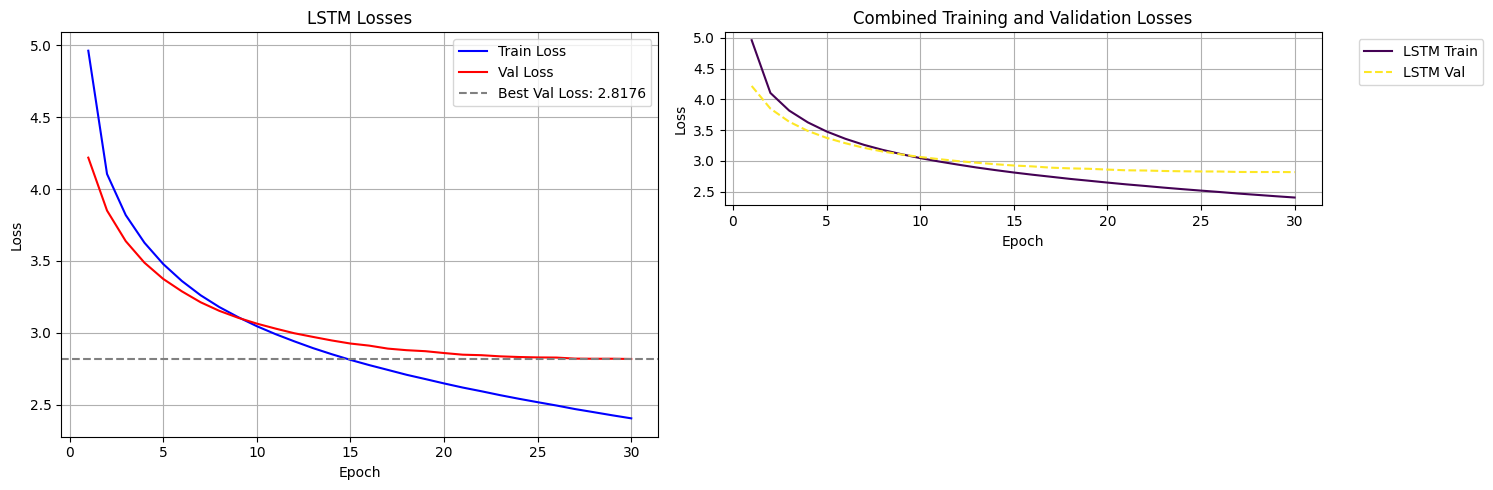

In [ ]:
def plot_all_losses(models_data):
    num_models = len(models_data)
    if num_models == 0:
        print("No model data to plot.")
        return

    plt.figure(figsize=(15, 5 * num_models))
    plot_index = 1

    # Individual plots per model
    for name, data in models_data.items():
        epochs_trained = len(data['train_losses'])
        if epochs_trained == 0:
            continue
        epochs = range(1, epochs_trained + 1)
        plt.subplot(num_models, 2, plot_index)
        plt.plot(epochs, data['train_losses'], 'b-', label='Train Loss')
        plt.plot(epochs, data['val_losses'], 'r-', label='Val Loss')
        plt.title(f'{name} Losses')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        if data['best_loss'] != float('inf'):
             plt.axhline(y=data['best_loss'], color='grey', linestyle='--', label=f'Best Val Loss: {data["best_loss"]:.4f}')
        plt.legend()
        plt.grid(True)
        plot_index += 1

    # Combined plot
    plt.subplot(2, 2, 2) # Position combined plot on the right
    colors = plt.cm.viridis(np.linspace(0, 1, num_models * 2)) # Color map for distinction
    color_idx = 0
    for name, data in models_data.items():
        epochs_trained = len(data['train_losses'])
        if epochs_trained == 0:
            continue
        epochs = range(1, epochs_trained + 1)
        plt.plot(epochs, data['train_losses'], linestyle='-', color=colors[color_idx], label=f'{name} Train')
        color_idx += 1
        plt.plot(epochs, data['val_losses'], linestyle='--', color=colors[color_idx], label=f'{name} Val')
        color_idx += 1

    plt.title('Combined Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_all_losses(models_dict)

## Generate Captions

Define a function to generate captions for a given image feature vector using a trained model.

In [ ]:
def generate_caption(model, img_feat, max_len=20):
    model.eval() # Ensure model is in eval mode
    # Start with the special <start> token index
    seq_indices = [word2idx[START_TOKEN]]
    with torch.no_grad():
        # Prepare image feature tensor
        feat_tensor = torch.tensor(img_feat, dtype=torch.float32).unsqueeze(0).to(device)
        for _ in range(max_len):
            # Prepare input sequence tensor
            inp_tensor = torch.tensor(seq_indices, dtype=torch.long).unsqueeze(0).to(device)
            # Current length for the model (excluding the image feature placeholder)
            current_length = [len(seq_indices)]
            # Get model output logits
            # Note: The model's forward expects 'lengths' which are lengths of original sequences *before* start token
            # For generation, we pass the current length of the generated sequence
            # The model internally handles the concatenation with the image feature
            # We need to adjust the lengths argument for the model's forward pass during generation.
            # Since we feed the sequence step-by-step, the length is just the current length.
            # The model expects lengths of the *input* sequence part (excluding image feature).
            # Let's adjust the forward pass or how we call it here.
            # Simpler approach: Modify forward pass slightly for generation or handle state.
            # Alternative: Feed dummy lengths, as packing isn't strictly needed for single item batch.
            # Let's try passing the current sequence length directly.
            # The model's forward expects lengths of the *original* sequence for packing.
            # During generation, we don't have padding, so packing isn't essential.
            # Let's modify the call slightly for generation if needed, or rely on model handling single instance.

            # --- Simplified call for generation (assuming batch size 1) ---
            # Project image features
            f = model.fc(feat_tensor).unsqueeze(1) # (1, 1, embed_dim)
            # Embed current sequence
            e = model.embed(inp_tensor) # (1, current_seq_len, embed_dim)
            # Concatenate
            x = torch.cat([f, e], dim=1) # (1, 1 + current_seq_len, embed_dim)
            # Pass through RNN layer (LSTM/GRU/RNN)
            # For generation, we typically need the hidden state, but this model structure doesn't explicitly return it.
            # Let's assume the standard forward works okay for batch size 1 without packing.
            # We might need hidden state passing for better generation, but let's stick to the current structure.
            if isinstance(model.lstm, nn.LSTM):
                 out, (hn, cn) = model.lstm(x) # Use hidden state if needed later
            elif isinstance(model.lstm, nn.GRU) or isinstance(model.lstm, nn.RNN):
                 out, hn = model.lstm(x)
            else:
                 out, _ = model.lstm(x) # Fallback

            # Get output for the last time step
            last_output = out[:, -1, :] # (1, hidden_dim)
            # Apply dropout and linear layer
            logits = model.linear(model.dropout(last_output)) # (1, vocab_size)
            # --- End Simplified Call ---

            # Get the predicted word index (greedy search)
            predicted_idx = logits.argmax(-1).item()
            seq_indices.append(predicted_idx)

            # Stop if <end> token is predicted
            if idx2word.get(predicted_idx) == END_TOKEN:
                break

    # Convert indices to words, excluding special tokens
    caption_words = [idx2word[i] for i in seq_indices if i not in (word2idx[START_TOKEN], word2idx[END_TOKEN], word2idx[PAD_TOKEN], word2idx[OOV_TOKEN])]
    return ' '.join(caption_words)

## Visualize Generated Captions

Select a random image from the validation set and generate captions using each of the trained (best) models. Display the image and the generated captions.

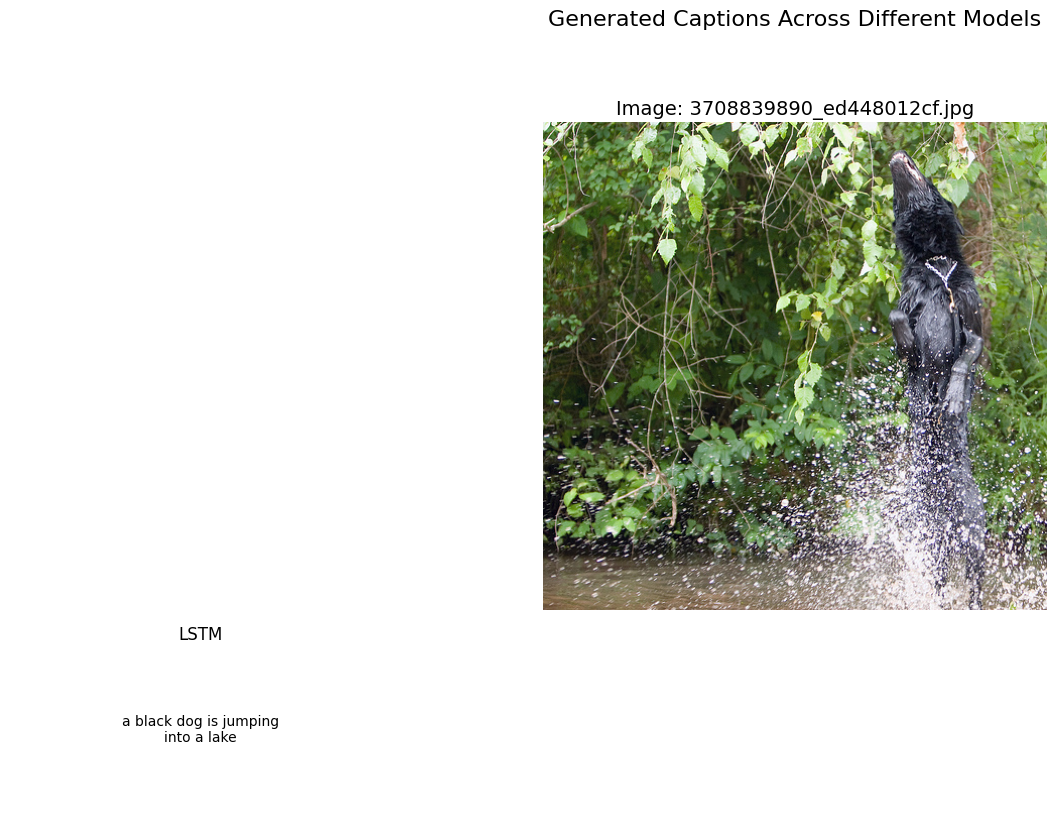

In [ ]:
# Generate captions and compare across all models for a single image with improved visualization
# Ensure models are loaded with best weights if not already done
lstm_model.load_state_dict(models_dict['LSTM']['best_state'])
# Sample one image from the validation set
if not val_df.empty:
    sample_img_name = random.choice(val_df['image'].unique())
    feat = img_features.get(sample_img_name)
    img_path = os.path.join(image_dir, sample_img_name)

    if feat is not None and os.path.exists(img_path):
        img = Image.open(img_path)

        # Generate captions for the single image using all models
        caps = {
            'LSTM': generate_caption(lstm_model, feat),
        }

        # --- Improved Visualization ---
        fig = plt.figure(figsize=(16, 8)) # Adjusted figure size
        gs = fig.add_gridspec(2, 4, width_ratios=[1, 1, 1, 1], height_ratios=[3, 1]) # GridSpec for layout

        # Display the image spanning top row
        ax_img = fig.add_subplot(gs[0, :])
        ax_img.imshow(img)
        ax_img.axis('off')
        ax_img.set_title(f"Image: {sample_img_name}", fontsize=14)

        # Display each caption in the bottom row
        for i, (name, cap) in enumerate(caps.items()):
            ax_cap = fig.add_subplot(gs[1, i])
            wrapped_caption = textwrap.fill(cap if cap else "[No caption generated]", width=25)  # Wrap long captions
            ax_cap.text(0.5, 0.5, f'{wrapped_caption}', ha='center', va='center', fontsize=10, wrap=True)
            ax_cap.axis('off')
            ax_cap.set_title(name, fontsize=12)

        fig.suptitle("Generated Captions Across Different Models", fontsize=16, y=1.02)
        plt.tight_layout(rect=[0, 0, 1, 0.97]) # Adjust layout
        plt.show()
    else:
        print(f"Could not load image or features for {sample_img_name}")
else:
    print("Validation dataframe is empty, cannot sample image.")

streamlit

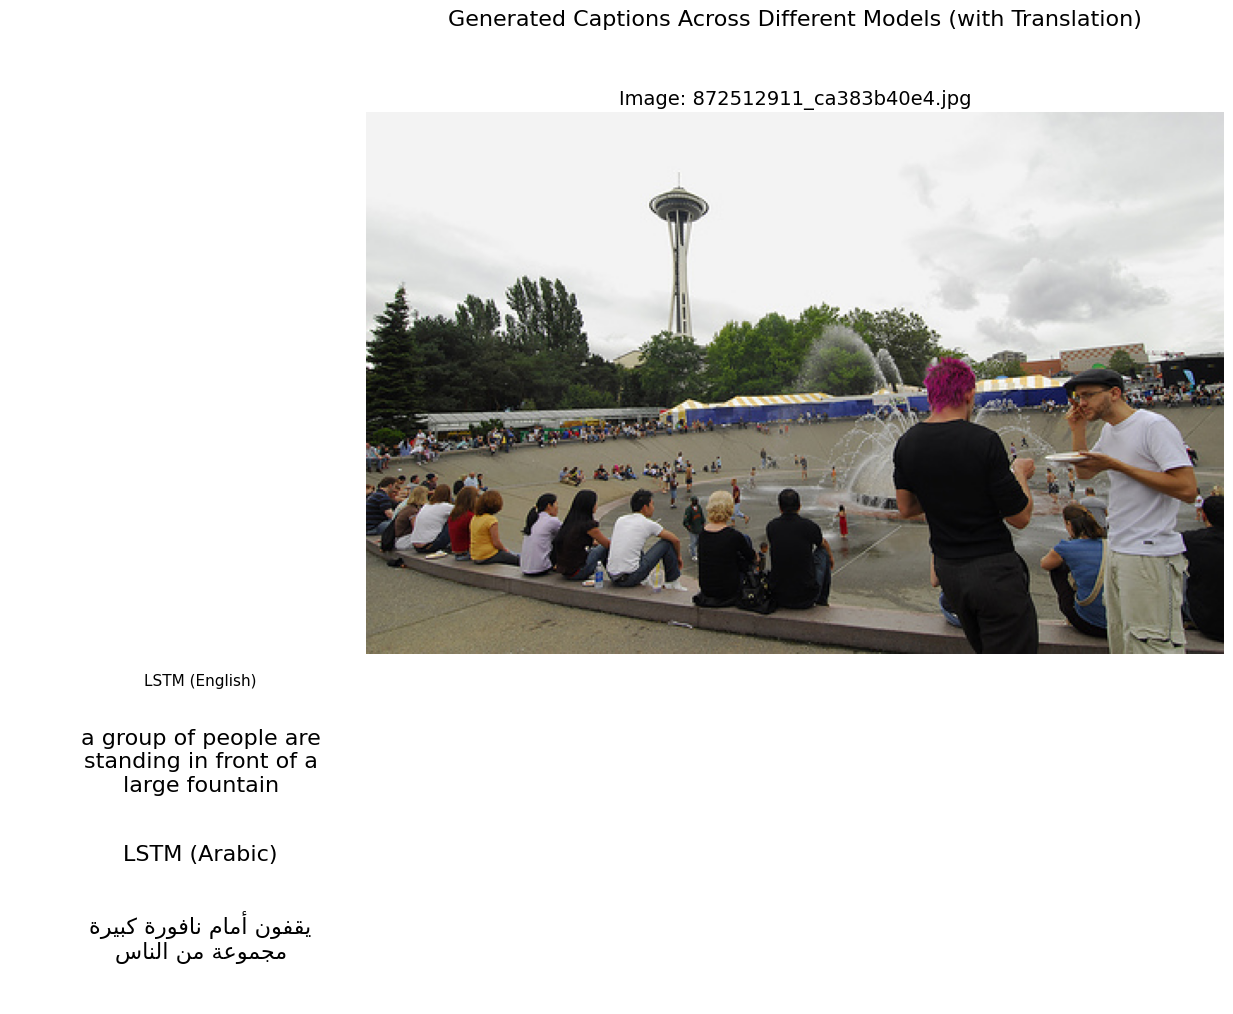

In [ ]:


# --- Function to Translate ---
def translate_caption(caption_text, model, tokenizer):
    if not model or not tokenizer or not caption_text:
        return "[Translation unavailable or empty caption]"
    # Prepare input for Helsinki-NLP model
    src_text = [f">>ara<< {caption_text}"]
    try:
        with torch.no_grad():
            translated = model.generate(**tokenizer(src_text, return_tensors="pt", padding=True).to(device))
        translated_text = tokenizer.decode(translated[0], skip_special_tokens=True)
        return translated_text
    except Exception as e:
        print(f"Error during translation: {e}")
        return "[Translation error]"

# Sample one image from the validation set
if not val_df.empty:
    sample_img_name = random.choice(val_df['image'].unique())
    feat = img_features.get(sample_img_name)
    img_path = os.path.join(image_dir, sample_img_name)

    if feat is not None and os.path.exists(img_path):
        img = Image.open(img_path)

        # Generate captions for the single image using all models
        caps = {
            'LSTM': generate_caption(lstm_model, feat),
        }

        # Translate captions
        translated_caps = {name: translate_caption(cap, translation_model, translation_tokenizer) for name, cap in caps.items()}

        # --- Improved Visualization ---
        fig = plt.figure(figsize=(16, 10)) # Adjusted figure size for translation
        gs = fig.add_gridspec(3, 4, width_ratios=[1, 1, 1, 1], height_ratios=[4, 1, 1]) # GridSpec for layout (image, eng, ara)

        # Display the image spanning top row
        ax_img = fig.add_subplot(gs[0, :])
        ax_img.imshow(img)
        ax_img.axis('off')
        ax_img.set_title(f"Image: {sample_img_name}", fontsize=14)

        # Display each caption and its translation
        for i, (name, cap) in enumerate(caps.items()):
            # English Caption
            ax_cap_en = fig.add_subplot(gs[1, i])
            wrapped_caption_en = textwrap.fill(cap if cap else "[No caption generated]", width=25)  # Wrap long captions
            ax_cap_en.text(0.5, 0.5, f'{wrapped_caption_en}', ha='center', va='center', fontsize=16, wrap=True)
            ax_cap_en.axis('off')
            ax_cap_en.set_title(f"{name} (English)", fontsize=11)

            # Arabic Translation
            ax_cap_ar = fig.add_subplot(gs[2, i])
            translated_text = translated_caps.get(name, "[Translation failed]")
            # Reshape and apply bidi algorithm for correct Arabic display
            reshaped_text = arabic_reshaper.reshape(translated_text)
            bidi_text = get_display(reshaped_text)
            # Basic wrapping for Arabic
            wrapped_caption_ar = textwrap.fill(bidi_text, width=25)
            # Note: Matplotlib might still have issues rendering complex scripts perfectly without specific fonts.
            ax_cap_ar.text(0.5, 0.5, f'{wrapped_caption_ar}', ha='center', va='center', fontsize=16, wrap=True)
            ax_cap_ar.axis('off')
            ax_cap_ar.set_title(f"{name} (Arabic)", fontsize=16)

        fig.suptitle("Generated Captions Across Different Models (with Translation)", fontsize=16, y=1.01)
        plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout
        plt.show()
    else:
        print(f"Could not load image or features for {sample_img_name}")
else:
    print("Validation dataframe is empty, cannot sample image.")